<a href="https://colab.research.google.com/github/ee17b031-iittp/DeepSAT-6-Satellite-Image-Classification/blob/master/deepsat_6_vgg_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $ Importing \, Dependencies $ #

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import xlrd
import pandas as pd
import scipy as sp
import io
from math import sqrt
from math import pi
from math import exp
from google.colab.patches import cv2_imshow
from sklearn.manifold import TSNE
import os
import glob
from sklearn.model_selection import StratifiedKFold
import scipy.io as sio
import plotly.graph_objects as go
from PIL import Image
# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve,f1_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage import data
import seaborn as sns; sns.set()
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.engine import Model
from keras import callbacks
from keras import optimizers
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras import backend as K
from keras.callbacks import *
import tensorflow as tf

Using TensorFlow backend.


#$ Loading \, Dataset$#

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
file_path='/content/gdrive/My Drive/deepsat-sat6/'

In [ ]:
#importing_datasets
x_train = pd.read_csv(file_path+'X_train_sat6.csv',header=None) #This will kill the available memory on the kaggle machine :\
y_train = pd.read_csv(file_path+'y_train_sat6.csv',header=None)
x_train = x_train.values.reshape(x_train.shape[0],28,28,4).astype(np.float32)
y_train = y_train.values.astype(np.float32)

x_test = pd.read_csv(file_path+'X_test_sat6.csv',header=None)
y_test = pd.read_csv(file_path+'y_test_sat6.csv',header=None)
x_test = x_test.values.reshape(x_test.shape[0],28,28,4).astype(np.float32)
y_test = y_test.values.astype(np.float32)

# $Train-Val \, Split $

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

#$ Data \, Preprocessing$#

In [ ]:
dim=(32,32)
x_train =np.array([cv2.resize(x, dim, interpolation = cv2.INTER_AREA) for x in x_train])
x_val = np.array([cv2.resize(x, dim, interpolation = cv2.INTER_AREA) for x in x_val])
x_test = np.array([cv2.resize(x, dim, interpolation = cv2.INTER_AREA) for x in x_test])

In [ ]:
#not using the fourth channel-NIR
x_train=x_train[:,:,:,0:3]
x_val=x_val[:,:,:,0:3]
x_test=x_test[:,:,:,0:3]

In [ ]:
means=np.mean(x_train,axis=0)
x_train=(x_train-means)/255
x_test=(x_test-means)/255
x_val=(x_val-means)/255

#$Cyclic \, Learning \, Rate$#

In [ ]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

#$ One\, Cycle \, Policy$#

In [ ]:
# Implement One Cycle Policy Algorithm in the Keras Callback Class
class Onecycle(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())
            

#$ Learning \, Range \, Test $#
$ For \, completely \, freezed \, model \, (pre-trained \, layers) \, with \, an \, added \, classifier \, block$

In [ ]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
last = base_model.layers[-1].output

In [ ]:
last=GlobalAveragePooling2D()(last)
last=Dense(512,name='dense_top_1')(last)
x=BatchNormalization(name='batch_norm_top_1')(last)
x=Activation('relu',name='activation_top_1')(x)
x=Dense(256,name='dense_top_2')(x)
x=BatchNormalization(name='batch_norm_top_2')(x)
x=Activation('relu',name='activation_top_2')(x)
pred=Dense(6, activation='softmax',name='dense_top_3')(x)
new_model=Model(base_model.input,pred)

In [ ]:
for layer in base_model.layers:
     layer.trainable = False

In [ ]:
new_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
for layer in new_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f1abec8ff60> False
<keras.layers.convolutional.Conv2D object at 0x7f1abec8fc18> False
<keras.layers.convolutional.Conv2D object at 0x7f1abec8fd30> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1abed1ccc0> False
<keras.layers.convolutional.Conv2D object at 0x7f1abed1c978> False
<keras.layers.convolutional.Conv2D object at 0x7f1abecb4978> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1abecb3b70> False
<keras.layers.convolutional.Conv2D object at 0x7f1abecb3cf8> False
<keras.layers.convolutional.Conv2D object at 0x7f1abe471ef0> False
<keras.layers.convolutional.Conv2D object at 0x7f1abe472550> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1abe472dd8> False
<keras.layers.convolutional.Conv2D object at 0x7f1abe472da0> False
<keras.layers.convolutional.Conv2D object at 0x7f1abe4a0b00> False
<keras.layers.convolutional.Conv2D object at 0x7f1abe6046a0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1abe604eb8>

In [ ]:
clr = CyclicLR(base_lr=1e-5, max_lr=2,
                        step_size=4*2295)

In [ ]:
history = new_model.fit(x_train,
                        y_train, 
                        batch_size=120, 
                        epochs=4,
                        validation_data=(x_val,y_val),
                        callbacks=[clr], 
                        verbose=1)

Train on 275400 samples, validate on 48600 samples
Epoch 1/4
275400/275400 [==============================] - 280s 1ms/step - loss: 0.2281 - accuracy: 0.9188 - val_loss: 0.4808 - val_accuracy: 0.8605
Epoch 2/4
275400/275400 [==============================] - 279s 1ms/step - loss: 0.4712 - accuracy: 0.8459 - val_loss: 1.2160 - val_accuracy: 0.6696
Epoch 3/4
275400/275400 [==============================] - 278s 1ms/step - loss: 0.8144 - accuracy: 0.7496 - val_loss: 1.4902 - val_accuracy: 0.5934
Epoch 4/4
275400/275400 [==============================] - 282s 1ms/step - loss: 1.4674 - accuracy: 0.5055 - val_loss: 1.3768 - val_accuracy: 0.3714


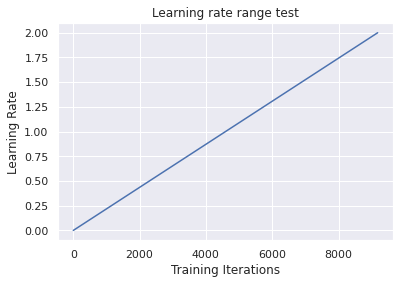

In [ ]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("Learning rate range test")
plt.plot(clr.history['iterations'], clr.history['lr'])

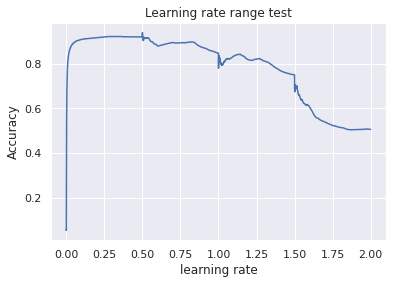

In [ ]:
h = clr.history
lr = h['lr']
acc = h['accuracy']
plt.xlabel('learning rate')
plt.ylabel('Accuracy')
plt.title("Learning rate range test")
plt.plot(lr,acc)

In [ ]:
for i in range(5000):
  print(lr[i],acc[i])

Streaming output truncated to the last 5000 lines.
0.00022786383 0.054166667
0.00044572767 0.083333336
0.0006635915 0.20208333
0.0008814553 0.28666666
0.0010993192 0.35833332
0.001317183 0.41428572
0.0015350468 0.45520833
0.0017529107 0.49907407
0.0019707745 0.53333336
0.0021886383 0.5530303
0.0024065021 0.57708335
0.002624366 0.6
0.0028422298 0.6220238
0.0030600936 0.63666666
0.0032779574 0.6458333
0.0034958213 0.6602941
0.003713685 0.6703704
0.003931549 0.68201756
0.0041494127 0.68958336
0.0043672766 0.697619
0.0045851404 0.70719695
0.004803004 0.7152174
0.005020868 0.72256947
0.005238732 0.72833335
0.0054565957 0.7346154
0.0056744595 0.7385802
0.0058923233 0.74494046
0.006110187 0.74971265
0.006328051 0.75555557
0.006545915 0.7599462
0.006763779 0.76640624
0.006981643 0.76969695
0.0071995067 0.7742647
0.0074173706 0.7778571
0.0076352344 0.78125
0.007853098 0.78468466
0.008070962 0.7890351
0.008288826 0.7929487
0.008506689 0.79479164
0.0087245535 0.797561
0.008942417 0.8003968
0.0091

#$ Training \, the \, model $#
$ Here \, all \, the \, layers \, of \, the \, pretrained \, model \, are \, frozen$

In [ ]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3))

In [ ]:
last = base_model.layers[-1].output

In [ ]:
last=GlobalAveragePooling2D()(last)
last=Dense(512,name='dense_top_1')(last)
x=BatchNormalization(name='batch_norm_top_1')(last)
x=Activation('relu',name='activation_top_1')(x)
x=Dense(256,name='dense_top_2')(x)
x=BatchNormalization(name='batch_norm_top_2')(x)
x=Activation('relu',name='activation_top_2')(x)
pred=Dense(6, activation='softmax',name='dense_top_3')(x)
new_model=Model(base_model.input,pred)

In [ ]:
for layer in base_model.layers:
     layer.trainable = False

In [ ]:
new_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
for layer in new_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f1a7d554d30> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7d554da0> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7d554fd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1a7d4ee588> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7d4ee400> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7d4eefd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1a7d4f1c50> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7d4f1a90> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7d4f56d8> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7d4fd358> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1a7d4fdda0> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7d4fdbe0> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7d506e48> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7d50c4a8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1a7d50cef0>

In [ ]:
new_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
clr = CyclicLR(base_lr=0.36/5, max_lr=0.36,
                        step_size=2295,mode='triangular2')

In [ ]:
checkpointer = ModelCheckpoint(monitor='val_loss',filepath='bottleneck_model_vgg16.weights.best.hdf5', verbose = 1, save_best_only=True)

In [ ]:
history = new_model.fit(x_train,
                        y_train, 
                        batch_size=120, 
                        epochs=15,
                        validation_data=(x_val,y_val),
                        callbacks=[clr,checkpointer], 
                        verbose=1)

Train on 275400 samples, validate on 48600 samples
Epoch 1/15
275400/275400 [==============================] - 283s 1ms/step - loss: 0.2115 - accuracy: 0.9278 - val_loss: 0.3837 - val_accuracy: 0.8798

Epoch 00001: val_loss improved from inf to 0.38370, saving model to bottleneck_model_vgg16.weights.best.hdf5
Epoch 2/15
275400/275400 [==============================] - 281s 1ms/step - loss: 0.1247 - accuracy: 0.9566 - val_loss: 0.0888 - val_accuracy: 0.9690

Epoch 00002: val_loss improved from 0.38370 to 0.08878, saving model to bottleneck_model_vgg16.weights.best.hdf5
Epoch 3/15
275400/275400 [==============================] - 279s 1ms/step - loss: 0.1072 - accuracy: 0.9621 - val_loss: 0.2148 - val_accuracy: 0.9433

Epoch 00003: val_loss did not improve from 0.08878
Epoch 4/15
275400/275400 [==============================] - 280s 1ms/step - loss: 0.0941 - accuracy: 0.9669 - val_loss: 0.0762 - val_accuracy: 0.9735

Epoch 00004: val_loss improved from 0.08878 to 0.07621, saving model to 

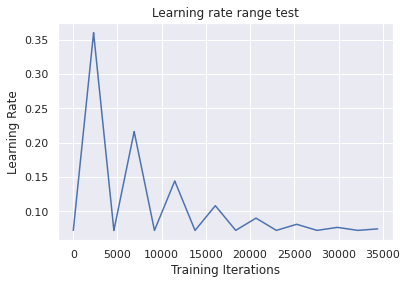

In [ ]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("Learning rate range test")
plt.plot(clr.history['iterations'], clr.history['lr'])

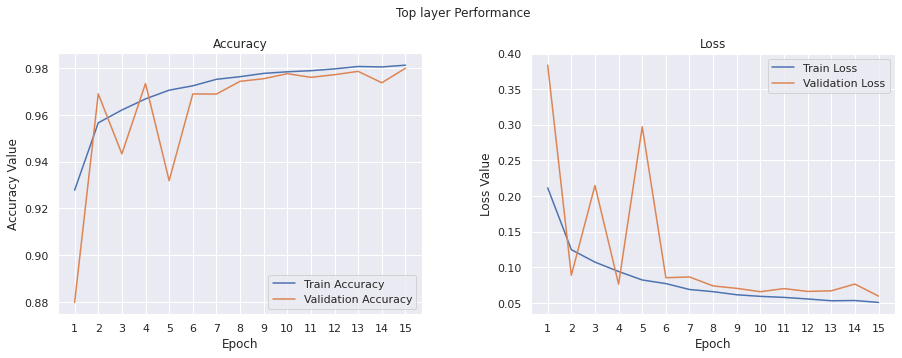

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Top layer Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,15+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

#$ Learning \, Range \, Test $#
$ Here \, some \, layers \, of \, the \, pre-trained \, model \, are \, set \, as \, trainable \, along \, with \, the \, classifier-block$

In [ ]:
final_base_model=vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3))

In [ ]:
last = final_base_model.layers[-1].output
last=GlobalAveragePooling2D()(last)
last=Dense(512,name='dense_top_1')(last)
x=BatchNormalization(name='batch_norm_top_1')(last)
x=Activation('relu',name='activation_top_1')(x)
x=Dense(256,name='dense_top_2')(x)
x=BatchNormalization(name='batch_norm_top_2')(x)
x=Activation('relu',name='activation_top_2')(x)
pred=Dense(6, activation='softmax',name='dense_top_3')(x)
final_model=Model(final_base_model.input,pred)

In [ ]:
final_model.load_weights('bottleneck_model_vgg16.weights.best.hdf5')

In [ ]:
final_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
for i in range(len(final_model.layers)-12):
  final_model.layers[i].trainable = False

In [ ]:
for layer in final_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f1a7cc26c18> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7cc26d68> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7cc26fd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1a7cc26748> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7cc26940> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7ccbfd68> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1a7ccb6c88> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7cb8cc88> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7ccc97b8> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7cb2a0b8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1a7cb2ae10> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7cb2ac50> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7cb33eb8> False
<keras.layers.convolutional.Conv2D object at 0x7f1a7cb37518> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1a7cb37da0>

In [ ]:
final_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
final_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
clr = CyclicLR(base_lr=1e-7, max_lr=2,
                        step_size=4*2295)

In [ ]:
history = final_model.fit(x_train,
                        y_train, 
                        batch_size=120, 
                        epochs=4,
                        validation_data=(x_val,y_val),
                        callbacks=[clr], 
                        verbose=1)

Train on 275400 samples, validate on 48600 samples
Epoch 1/4
275400/275400 [==============================] - 601s 2ms/step - loss: 0.2027 - accuracy: 0.9364 - val_loss: 21.0602 - val_accuracy: 0.7147
Epoch 2/4
275400/275400 [==============================] - 602s 2ms/step - loss: 0.4340 - accuracy: 0.8517 - val_loss: 63.3463 - val_accuracy: 0.6394
Epoch 3/4
275400/275400 [==============================] - 615s 2ms/step - loss: 0.7867 - accuracy: 0.8528 - val_loss: 66597.3665 - val_accuracy: 0.3785
Epoch 4/4
275400/275400 [==============================] - 591s 2ms/step - loss: 1.5508 - accuracy: 0.4836 - val_loss: 1.1873 - val_accuracy: 0.5340


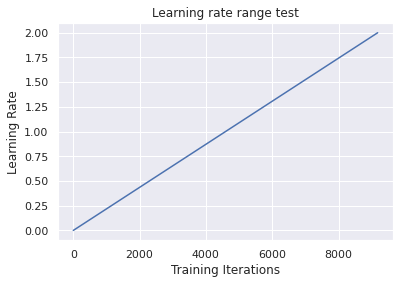

In [ ]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("Learning rate range test")
plt.plot(clr.history['iterations'], clr.history['lr'])

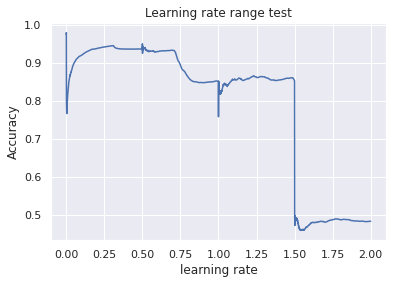

In [ ]:
h = clr.history
lr = h['lr']
acc = h['accuracy']
plt.xlabel('learning rate')
plt.ylabel('Accuracy')
plt.title("Learning rate range test")
plt.plot(lr,acc)

In [ ]:
for i in range(5000):
  print(lr[i],acc[i])

Streaming output truncated to the last 5000 lines.
0.00021796492 0.9791667
0.00043582983 0.8194444
0.00065369473 0.81875
0.00087155966 0.815
0.0010894246 0.80138886
0.0013072895 0.7940476
0.0015251543 0.790625
0.0017430193 0.77962965
0.0019608843 0.77916664
0.002178749 0.7772727
0.002396614 0.7763889
0.002614479 0.7724359
0.0028323438 0.77261907
0.0030502088 0.7677778
0.0032680738 0.76770836
0.0034859385 0.76666665
0.0037038035 0.76805556
0.0039216685 0.7719298
0.0041395333 0.7733333
0.0043573985 0.7734127
0.0045752632 0.7768939
0.004793128 0.7753623
0.005010993 0.7809028
0.005228858 0.783
0.0054467227 0.7862179
0.005664588 0.78765434
0.0058824527 0.7904762
0.0061003175 0.7933908
0.0063181827 0.79555553
0.0065360474 0.7981183
0.006753912 0.8
0.0069717774 0.80277777
0.007189642 0.80514705
0.007407507 0.80690473
0.007625372 0.8076389
0.007843236 0.8096847
0.008061102 0.81096494
0.008278967 0.8119658
0.008496831 0.81104165
0.008714696 0.8121951
0.008932562 0.8126984
0.009150426 0.8145349


In [ ]:
for i in range(5000,10000):
  print(lr[i],acc[i])

1.0893247 0.54476887
1.0895425 0.54453886
1.0897604 0.54465294
1.0899782 0.54458535
1.0901961 0.54447794
1.090414 0.544351
1.0906318 0.5442246
1.0908498 0.5439793
1.0910676 0.54397374
1.0912855 0.54418653
1.0915033 0.5442003
1.0917212 0.5440363
1.0919391 0.5440701
1.0921569 0.5438483
1.0923748 0.5437059
1.0925926 0.5436033
1.0928105 0.5434231
1.0930284 0.54332167
1.0932462 0.5432401
1.0934641 0.5431977
1.0936819 0.54303944
1.0938998 0.54288197
1.0941176 0.54266745
1.0943356 0.54279953
1.0945535 0.54262453
1.0947713 0.54250765
1.0949892 0.5424485
1.095207 0.5424087
1.0954249 0.542407
1.0956428 0.5425758
1.0958606 0.54266816
1.0960785 0.5426659
1.0962963 0.5427013
1.0965142 0.54264265
1.096732 0.542397
1.0969499 0.5425262
1.0971678 0.542431
1.0973856 0.5425595
1.0976036 0.54240906
1.0978214 0.54246294
1.0980393 0.5424982
1.0982572 0.542441
1.098475 0.54225534
1.0986929 0.54229075
1.0989107 0.54214287
1.0991286 0.5420687
1.0993464 0.5421043
1.0995643 0.5420852
1.0997822 0.5420298
1.1 0.54

IndexError: ignored

#$ Training \, the \, model $#
$ Here \, some \, layers \, of \, the \, pre-trained \, model \, are \, set \, as \, trainable \, along \, with \, the \, classifier-block$

In [ ]:
final_base_model=vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
last = final_base_model.layers[-1].output
last=GlobalAveragePooling2D()(last)
last=Dense(512,name='dense_top_1')(last)
x=BatchNormalization(name='batch_norm_top_1')(last)
x=Activation('relu',name='activation_top_1')(x)
x=Dense(256,name='dense_top_2')(x)
x=BatchNormalization(name='batch_norm_top_2')(x)
x=Activation('relu',name='activation_top_2')(x)
pred=Dense(6, activation='softmax',name='dense_top_3')(x)
final_model=Model(final_base_model.input,pred)

In [ ]:
final_model.load_weights('bottleneck_model_vgg16.weights.best.hdf5')

In [ ]:
final_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
for i in range(len(final_model.layers)-12):
  final_model.layers[i].trainable = False

In [ ]:
clr = CyclicLR(base_lr=0.31/5, max_lr=0.31,
                        step_size=4950,mode='triangular2')

In [ ]:
checkpointer = ModelCheckpoint(monitor='val_loss',filepath='final_model_vgg16.weights.best.hdf5', verbose = 1, save_best_only=True)

In [ ]:
for layer in final_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f44fcb8f470> False
<keras.layers.convolutional.Conv2D object at 0x7f44fcb8f780> False
<keras.layers.convolutional.Conv2D object at 0x7f44fcb8f710> False
<keras.layers.pooling.MaxPooling2D object at 0x7f44fcb8fc18> False
<keras.layers.convolutional.Conv2D object at 0x7f44fcb8fbe0> False
<keras.layers.convolutional.Conv2D object at 0x7f44fcbd7f28> False
<keras.layers.pooling.MaxPooling2D object at 0x7f44fcba7a20> False
<keras.layers.convolutional.Conv2D object at 0x7f44fcba7ba8> False
<keras.layers.convolutional.Conv2D object at 0x7f44fb2485c0> False
<keras.layers.convolutional.Conv2D object at 0x7f44fb255400> False
<keras.layers.pooling.MaxPooling2D object at 0x7f44fb255e48> False
<keras.layers.convolutional.Conv2D object at 0x7f44fb255c88> False
<keras.layers.convolutional.Conv2D object at 0x7f44fb274ef0> False
<keras.layers.convolutional.Conv2D object at 0x7f44fb240550> False
<keras.layers.pooling.MaxPooling2D object at 0x7f44fb240dd8>

In [ ]:
final_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
final_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
history = final_model.fit(x_train,
                        y_train, 
                        batch_size=60, 
                        epochs=5,
                        validation_data=(x_val,y_val),
                        callbacks=[clr,checkpointer], 
                        verbose=1)

Train on 275400 samples, validate on 48600 samples
Epoch 1/5
275400/275400 [==============================] - 622s 2ms/step - loss: 0.1724 - accuracy: 0.9444 - val_loss: 0.4631 - val_accuracy: 0.8749

Epoch 00001: val_loss improved from inf to 0.46309, saving model to final_model_vgg16.weights.best.hdf5
Epoch 2/5
275400/275400 [==============================] - 607s 2ms/step - loss: 0.1037 - accuracy: 0.9677 - val_loss: 0.0566 - val_accuracy: 0.9810

Epoch 00002: val_loss improved from 0.46309 to 0.05661, saving model to final_model_vgg16.weights.best.hdf5
Epoch 3/5
275400/275400 [==============================] - 590s 2ms/step - loss: 0.0650 - accuracy: 0.9788 - val_loss: 0.1289 - val_accuracy: 0.9557

Epoch 00003: val_loss did not improve from 0.05661
Epoch 4/5
275400/275400 [==============================] - 591s 2ms/step - loss: 0.0683 - accuracy: 0.9785 - val_loss: 0.0522 - val_accuracy: 0.9831

Epoch 00004: val_loss improved from 0.05661 to 0.05219, saving model to final_model_vg

In [ ]:
final_model.load_weights('final_model_vgg16.weights.best.hdf5')

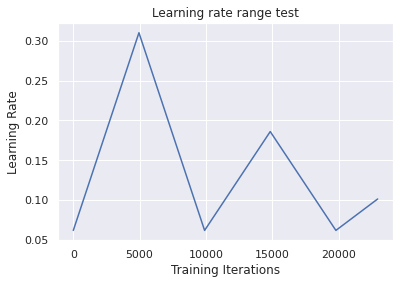

In [ ]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("Learning rate range test")
plt.plot(clr.history['iterations'], clr.history['lr'])

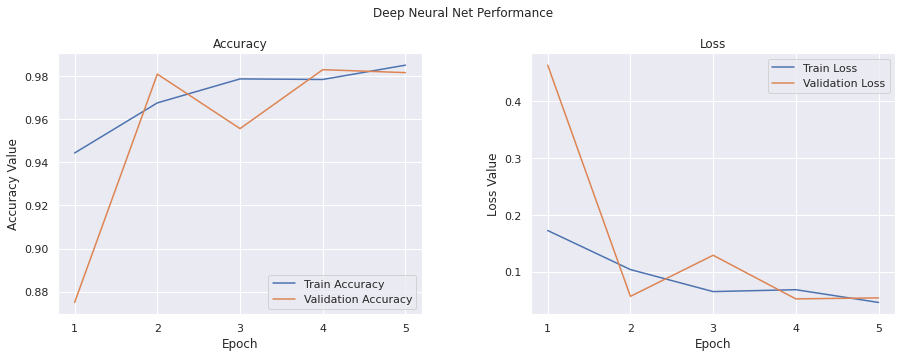

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,5+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

#$Testing \, the \, model$

In [ ]:
print("test accuracy = ",final_model.evaluate(x_test,y_test))
y_pred_class = final_model.predict(x_test, verbose=1)

81000/81000 [==============================] - 88s 1ms/step
test accuracy =  [0.048343804156915055, 0.9845308661460876]
81000/81000 [==============================] - 82s 1ms/step


In [ ]:
print('f1_score =',f1_score(np.argmax(y_test,axis=-1),np.argmax(y_pred_class,axis=-1),average='weighted'))

f1_score = 0.9845123724131472


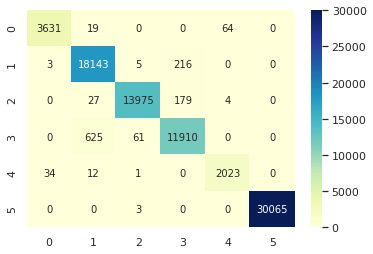

In [ ]:
cm=confusion_matrix(np.argmax(y_test,axis=-1),np.argmax(y_pred_class,axis=-1))
fig = go.Figure(data=[go.Table(header=dict(values=['Confusion Matrix ','1','2','3','4','5','6']),
                 cells=dict(values=[[
                                     'predicted as 1','predicted as 2','predicted as 3',
                                     'predicted as 4','predicted as 5',
                                     'predicted as 6'
                                    ],cm[0,:],cm[1,:],cm[2,:],
                                    cm[3,:],cm[4,:],cm[5,:]
                                    ]))])
fig.show()
ax = sns.heatmap(cm, annot=True,cmap="YlGnBu", fmt="d")

In [ ]:
label_names=['barren land', 'trees', 'grassland', 'roads', 'buildings', 'water bodies']
print(classification_report(np.argmax(y_test,axis=-1),np.argmax(y_pred_class,axis=-1),
	target_names=label_names))

              precision    recall  f1-score   support

 barren land       0.99      0.98      0.98      3714
       trees       0.96      0.99      0.98     18367
   grassland       1.00      0.99      0.99     14185
       roads       0.97      0.95      0.96     12596
   buildings       0.97      0.98      0.97      2070
water bodies       1.00      1.00      1.00     30068

    accuracy                           0.98     81000
   macro avg       0.98      0.98      0.98     81000
weighted avg       0.98      0.98      0.98     81000

